In [1]:
using CSV
using DataFrames
using Random
using Statistics

In [2]:
# Load the ratings data
path="data/ml-32m/"
ratings = CSV.read(path*"ratings.csv", DataFrame)
# Count the number of ratings per user and per movie
user_counts = combine(groupby(ratings, :userId), nrow => :count)
movie_counts = combine(groupby(ratings, :movieId), nrow => :count)


Row,movieId,count
,Int64,Int64
1,1,68997
2,2,28904
3,3,13134
4,4,2806
5,5,13154
6,6,29490
7,7,13585
8,8,1510
9,9,4154


In [3]:
# Set thresholds
min_ratings_per_user = 1200
min_ratings_per_movie =5000

# Get active users and popular movies as Sets
active_users = Set(user_counts[user_counts.count .>= min_ratings_per_user, :userId])
popular_movies = Set(movie_counts[movie_counts.count .>= min_ratings_per_movie, :movieId])

# Create a dense subset using Sets for faster lookup
dense_ratings = filter(row -> row.userId in active_users && row.movieId in popular_movies, ratings)


# Split active users into training and test sets
train_ratio = 0.8
num_train = Int(floor(train_ratio * length(active_users)))
train_users = Random.shuffle(collect(active_users))[1:num_train]
test_users = setdiff(active_users, train_users)

#train_users
#test_users

Set{Int64} with 481 elements:
  189883
  61392
  20994
  187073
  40603
  21914
  133518
  51922
  143337
  21637
  44117
  198721
  85312
  151127
  181477
  75348
  6324
  23476
  199930
  ⋮ 

In [4]:
length(active_users), length(train_users), length(test_users),length(popular_movies), size(dense_ratings)

(2401, 1920, 481, 1489, (1810904, 4))

In [5]:
struct RatingsData
    users::Set{Int}
    movies::Set{Int}
    ratings::Matrix{Union{Float64, Missing}}
    #imputed_ratings::Matrix{Float64}
    user_to_idx::Dict{Int, Int}
    movie_to_idx::Dict{Int, Int}
end

function CreateRatingStruct(active_users, popular_movies, dense_ratings)
    user_to_idx = Dict(user => idx for (idx, user) in enumerate(active_users))
    movie_to_idx = Dict(movie => idx for (idx, movie) in enumerate(popular_movies))
    ratings_matrix = Matrix{Union{Float64, Missing}}(missing, length(active_users), length(popular_movies))
    for row in eachrow(dense_ratings)
        user_idx = user_to_idx[row.userId]
        movie_idx = movie_to_idx[row.movieId]
        ratings_matrix[user_idx, movie_idx] = row.rating
    end
    mean_rating = mean(skipmissing(ratings_matrix))
    #imputed_ratings_matrix = fill(mean_rating, length(active_users), length(popular_movies))
    return RatingsData(active_users, popular_movies, ratings_matrix, user_to_idx, movie_to_idx)
end

ratings_data = CreateRatingStruct(active_users, popular_movies, dense_ratings)

RatingsData(Set([189722, 15364, 189883, 95987, 178470, 90138, 1953, 28371, 167337, 92663  …  168828, 44961, 174589, 127151, 108304, 196215, 13536, 172433, 184144, 51117]), Set([77561, 2108, 4700, 1175, 1953, 719, 2288, 4901, 93510, 1028  …  1687, 2352, 1608, 1217, 3683, 3555, 96737, 65, 2054, 2248]), Union{Missing, Float64}[missing missing … 4.0 missing; 3.0 4.0 … 3.0 missing; … ; 0.5 3.0 … missing missing; 3.5 missing … missing 3.0], Dict(184144 => 2400, 15364 => 2, 51117 => 2401, 95987 => 4, 178470 => 5, 90138 => 6, 1953 => 7, 28371 => 8, 167337 => 9, 92663 => 10…), Dict(77561 => 1, 2108 => 2, 4700 => 3, 1175 => 4, 1953 => 5, 719 => 6, 2288 => 7, 4901 => 8, 93510 => 9, 1028 => 10…))

In [6]:
#split the data into training and test sets
#ratings_data.imputed_ratings[train_users, :]
train_indeces= [ratings_data.user_to_idx[user] for user in train_users]
test_indeces= [ratings_data.user_to_idx[user] for user in test_users]

train_matrix= ratings_data.ratings[train_indeces, :]
test_matrix= ratings_data.ratings[test_indeces, :]

function CreateImputedMatrix(mat,subtract_mean=false)
    #imputed_matrix= copy(mat)
    imputed_matrix=fill(NaN, size(mat))

    for i in 1:size(mat, 1)
        row= mat[i, :]
        mean_rating= mean(skipmissing(row))
        for j in 1:size(mat, 2)
            if ismissing(mat[i, j])
                imputed_matrix[i, j]= mean_rating
            else
                imputed_matrix[i, j]= mat[i, j]
            end
            if subtract_mean
                imputed_matrix[i, j]-= mean_rating
            end
    
        end
    end
    #imputed_matrix .= Float64().(imputed_matrix)
    return imputed_matrix
end
train_imputed_matrix= CreateImputedMatrix(train_matrix, true)
test_imputed_matrix= CreateImputedMatrix(test_matrix,true)


481×1489 Matrix{Float64}:
  0.0406977   0.0406977  -0.459302   …  -1.4593     0.540698   0.0
 -1.23456     0.0         0.26544       -2.23456    0.26544    0.0
  0.0880246   0.0         0.0           -2.41198   -1.41198    0.588025
  0.392621    0.0         0.0            0.0        0.392621   0.0
 -0.0673877   0.0        -0.0673877      0.0        0.0        0.0
  0.0         0.0729795  -2.92702    …   0.0        0.0        0.0
  0.0         0.0         0.0           -0.797508  -2.79751    0.702492
 -1.73294     0.0         0.0            0.0       -2.73294   -0.232942
 -0.0968421   0.0         0.0            0.0        0.0        0.0
  1.25035     0.0         0.250347      -2.24965    0.0        0.0
  ⋮                                  ⋱                        
  0.0950311   0.0        -0.904969       0.0        0.0        0.0
 -0.917112    0.0         0.0            0.0       -0.417112   0.0
 -0.661046    0.0         0.0            0.0       -1.66105    0.0
  0.0        -0.653558   

In [7]:
using LinearAlgebra

# Perform SVD decomposition
U, S, V = svd(train_imputed_matrix)
U

1920×1489 Matrix{Float64}:
 0.0235137    0.00570048  -0.00256667  …   0.0143716    -0.0530793
 0.0419984    0.0244331    0.0371892      -0.043789      0.0235922
 0.0238317   -0.0230874   -0.00953418     -0.00901608    0.0246348
 0.0129995   -0.0205771    0.0173972      -0.0246095    -0.0253719
 0.0250175    0.0168727    0.0264566       0.0294611    -0.010263
 0.0110056    0.00288816  -0.00256979  …   0.0212895     0.013731
 1.41378e-5  -1.74829e-5  -5.37433e-5     -0.000245683  -0.114177
 0.00559023  -0.0349728    0.00865985     -0.000315093   0.0178716
 0.0273563    0.0121728   -0.0170197       0.0420511     0.0126649
 0.0190713   -0.0208487   -0.0357492       0.0116485    -0.000305025
 ⋮                                     ⋱                
 0.019907     0.0123398   -0.00557968      0.0276054    -0.0130441
 0.0100321   -0.0104379   -0.0137872       0.00361873   -0.0243975
 0.025658    -0.00919334   0.0286452      -0.00183815   -0.0119671
 0.04114      0.0607672    0.0276317      -0.0

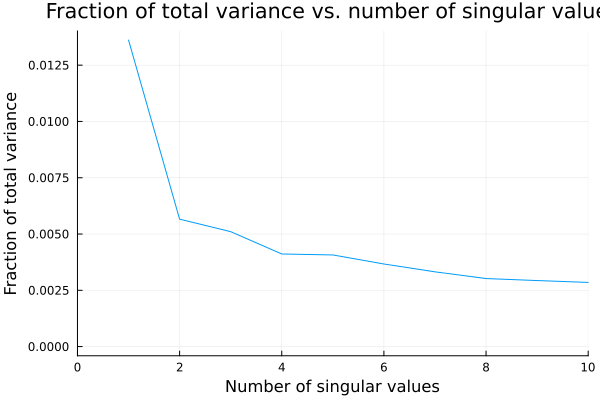

In [8]:
using Plots
plot(cumsum(S) ./ sum(S), legend=false, xlabel="Number of singular values", ylabel="Fraction of total variance", title="Fraction of total variance vs. number of singular values")
plot(S./sum(S), xlim=[0,10],legend=false, xlabel="Number of singular values", ylabel="Fraction of total variance", title="Fraction of total variance vs. number of singular values")

In [14]:
U

UndefVarError: UndefVarError: `U` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Cluster Centers:
[0.013856713886117665 0.018573565032483336 0.0086176126470375 0.013626286078663237 0.026358694815212417 0.03492817913890111 0.03494837038251013; -0.05281072253892678 0.016769301534698296 -0.021350517425030486 -0.002887191677987509 -0.020340010757315244 0.036270162252072066 0.005037558433810828]


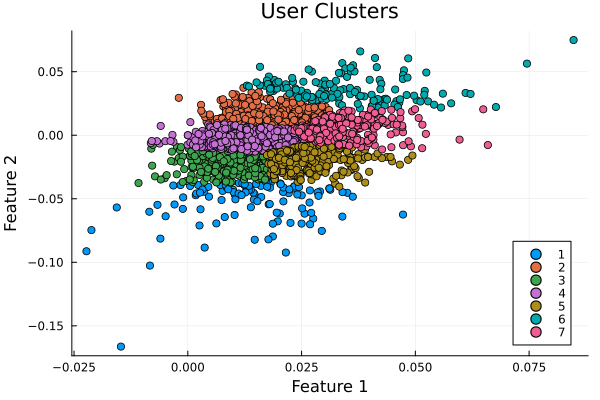

In [9]:
using Clustering
using Plots
k=2
num_clusters=7
U_k= U[:,1:k]
S_k= Diagonal(S[1:k])
V_k= V[:, 1:k]

approximation= (U * Diagonal(S)) * transpose(V)


# Assuming U_k_test is the user feature matrix without the first user's features
# U_k_test has dimensions (num_users - 1) x k, where k is the number of latent features

# Set the number of clusters

# Perform K-means clustering
kmeans_result = kmeans(transpose(U_k), num_clusters)

# Extract the cluster assignments for each user
cluster_assignments = kmeans_result.assignments

# Print the cluster centers
println("Cluster Centers:")
println(kmeans_result.centers)
scatter(U_k[:, 1], U_k[:, 2], group=cluster_assignments, xlabel="Feature 1", ylabel="Feature 2", title="User Clusters")

In [10]:
kmeans_result.centers

2×7 Matrix{Float64}:
 0.00944501   0.039346    0.0180598  …   0.0285572  0.0146715  0.0278022
 0.00949659  -0.0143027  -0.0112037     -0.0368354  0.0308672  0.0119404

In [17]:
U_k*S_k*transpose(V_k)

UndefVarError: UndefVarError: `U_k` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
#=
using Clustering
k=761
num_clusters=5
U_k= U[:,1:k]
S_k= Diagonal(S[1:k])
V_k= V[:, 1:k]
approx= U_k * S_k * transpose(V_k)
error= sum((approx .- train_imputed_matrix).^2)
=#

In [9]:
using DataStructures
cluster_movie_forecasts=transpose(kmeans_result.centers)*S_k*transpose(V_k)
num_movies= size(cluster_movie_forecasts, 2)
sorted_cluster_ratings= [sortperm(cluster_movie_forecasts[i, :], rev=true) for i in 1:num_clusters]
# Create an array of n empty Queues
function create_queues(num_clusters, num_movies, sorted_cluster_ratings)
    queues = [Queue{Int}() for _ in 1:num_clusters]
    for i in 1:num_clusters
        for j in 1:num_movies
            enqueue!(queues[i], sorted_cluster_ratings[i][j])
        end
    end
    return queues
end
queues= create_queues(num_clusters, num_movies, sorted_cluster_ratings)
queues[1]

Queue{Int64}(Deque [[346, 258, 465, 1396, 862, 682, 923, 1329, 1214, 772, 749, 1383, 965, 743, 336, 352, 786, 1319, 251, 875, 59, 486, 817, 782, 747, 845, 1148, 1398, 1429, 968, 1443, 431, 572, 28, 1192, 1042, 936, 1138, 114, 834, 833, 1313, 1359, 810, 562, 857, 1424, 1413, 1061, 469, 667, 306, 902, 41, 1062, 910, 1301, 492, 128, 206, 710, 1206, 756, 1360, 32, 406, 882, 1420, 816, 980, 229, 322, 740, 489, 671, 480, 900, 703, 203, 720, 69, 528, 1370, 190, 713, 707, 235, 388, 426, 1470, 1324, 941, 563, 462, 1364, 387, 1154, 617, 1081, 1161, 629, 292, 1406, 836, 19, 1197, 61, 898, 1114, 247, 1191, 1236, 722, 275, 1288, 279, 505, 1135, 215, 575, 885, 1305, 1053, 133, 392, 1317, 1141, 7, 595, 999, 748, 178, 830, 1273, 746, 728, 589, 1180, 66, 838, 432, 154, 1225, 1065, 410, 699, 435, 848, 439, 226, 912, 896, 692, 495, 570, 755, 521, 1173, 905, 94, 1352, 739, 1169, 399, 484, 368, 481, 634, 249, 881, 1022, 548, 177, 163, 1027, 894, 214, 1292, 507, 982, 835, 143, 329, 1174, 376, 424, 1389, 102

In [20]:
cluster_movie_forecasts[1, :]
sortperm(cluster_movie_forecasts[1, :], rev=true) 
sorted_cluster_ratings[1]
queues[1]
dequeue!(queues[1])

UndefVarError: UndefVarError: `cluster_movie_forecasts` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [21]:
using Distributions
using DataStructures

function pick_cluster(user_ind, alpha, counts)
    dirichlet_prior= Dirichlet(alpha+counts[user_ind, :])
    cluster_sample= rand(dirichlet_prior)
    cluster_dist= Categorical(cluster_sample)
    cluster= rand(cluster_dist)
    return cluster
end
num_steps=100
num_train= size(train_imputed_matrix, 1)
num_test= size(test_imputed_matrix, 1)
num_movies= size(cluster_movie_forecasts, 2)
alpha=ones(num_clusters)
counts= zeros(num_test, num_clusters)
global_train_mean_rating = mean(skipmissing(train_matrix))
means= zeros(num_test).+global_train_mean_rating
alpha+counts[1, :]
actual_error_arr=zeros(num_test, num_steps)
random_error_arr=zeros(num_test, num_steps)
total_rewards_arr=zeros(num_test, num_steps)
total_random_rewards_arr=zeros(num_test, num_steps)

mean_alpha=0.01

i=1


#rannk the movies for each cluster
cluster_movie_forecasts=transpose(kmeans_result.centers)*S_k*transpose(V_k)
println("cluster_movie_forecasts: ", size(cluster_movie_forecasts))
print("cluster_movie_forecasts: ", size(cluster_movie_forecasts))




user_ind=1
for user_ind in 1:num_test
    queues= create_queues(num_clusters, num_movies, sorted_cluster_ratings)
    for i in 1:num_steps
        cluster= pick_cluster(user_ind, alpha, counts)
        picked_movie=false
        true_user_rating=-Inf
        reward_rating=-Inf
        best_movie=0
        while !picked_movie
            if isempty(queues[cluster])
                break
            end
            best_movie= dequeue!(queues[cluster])
            if !ismissing(test_matrix[user_ind, best_movie])
                true_user_rating= test_imputed_matrix[user_ind, best_movie]
                reward_rating=test_matrix[user_ind, best_movie]
                picked_movie=true
            end
        end
        #=
        #randome cluster movie
        cluster_rand=rand(1:num_clusters)
        picked_rand_movie=false
        rand_true_user_rating=-Inf
        rand_reward_rating=-Inf
        rand_best_movie=0
        while !picked_movie
            if isempty(queues[cluster_rand])
                break
            end
            rand_best_movie= dequeue!(queues[rand_cluster])
            if !ismissing(test_matrix[user_ind, rand_best_movie])
                rand_true_user_rating= test_imputed_matrix[user_ind, best_movie]
                rand_reward_rating=test_matrix[user_ind, best_movie]
                rand_picked_movie=true
            end
        end 
        =#
        if best_movie==0
            break
        end
        best_movie_forecasts= cluster_movie_forecasts[:, best_movie]
        #compare to the actual rating
        error= (best_movie_forecasts .- (true_user_rating-means[user_ind]*0)).^2
        best_guess=argmin(error)
        actual_error= error[cluster] 
        random_guess=error[rand(1:num_clusters)]
        #random_guess= error[best_guess]
        #println("Actual Error: ", actual_error)
        #println("Random Error: ", random_guess)
        total_reward=reward_rating/5
        #total_random_reward=rand_reward_rating/5

        actual_error_arr[user_ind, i]= actual_error
        random_error_arr[user_ind, i]= random_guess
        total_rewards_arr[user_ind, i]= total_reward
        #total_random_rewards_arr[user_ind, i]= total_random_reward
        counts[user_ind, best_guess]+=1
        #means[user_ind]=means[user_ind]*(i/(i+1))+true_user_rating/(i+1)
        means[user_ind]=means[user_ind]+(true_user_rating-means[user_ind])*mean_alpha
    end
end
a=sum(actual_error_arr-random_error_arr, dims=1)
a=transpose(sum(actual_error_arr, dims=1))-transpose(sum(random_error_arr, dims=1))
plot(a)

#plot(transpose(sum(total_rewards_arr, dims=1)), label="Total Reward")
#sum(actual_error_arr- random_error_arr, dims=1)

UndefVarError: UndefVarError: `train_imputed_matrix` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
transpose(kmeans_result.centers)*S_k*V_k

UndefVarError: UndefVarError: `kmeans_result` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

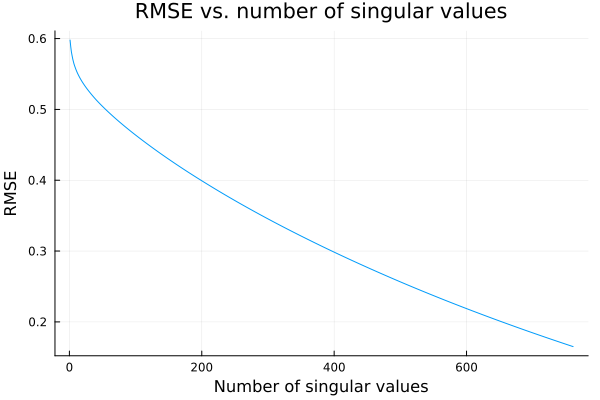

In [9]:
# Compute the approximation of the training matrix
function ComputeApproximation(U, S, V, k)
    return U[:, 1:k] * Diagonal(S[1:k]) * transpose(V[:,1:k])

end

function ComputeRMSE(U, S, V, k, test_matrix)
    approx_matrix = ComputeApproximation(U, S, V, k)
    rmse = sqrt(mean((test_matrix .- approx_matrix).^2))
    return rmse
end

#compute the RMSE and print out
k_values = 1:761
rmse_values = [ComputeRMSE(U, S, V, k, train_imputed_matrix) for k in k_values]
#println(rmse_values)
#approx_matrix= ComputeApproximation(U, S, V, k)
#U[:, 1:k]* Diagonal(S[1:k])*transpose(V[:, 1:k])
#train_imputed_matrix
plot(k_values, rmse_values, legend=false, xlabel="Number of singular values", ylabel="RMSE", title="RMSE vs. number of singular values")




In [29]:
using Clustering

# Assuming U_k_test is the user feature matrix without the first user's features
# U_k_test has dimensions (num_users - 1) x k, where k is the number of latent features

# Set the number of clusters
num_clusters = 10# You can experiment with different values

# Perform K-means clustering
kmeans_result = kmeans(transpose(U_k_test), num_clusters)

# Extract the cluster assignments for each user
cluster_assignments = kmeans_result.assignments

# Print the cluster centers
println("Cluster Centers:")
println(kmeans_result.centers)
scatter(U_k_test[:, 1], U_k_test[:, 2], group=cluster_assignments, xlabel="Feature 1", ylabel="Feature 2", title="User Clusters")

UndefVarError: UndefVarError: `U_k_test` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

set up for creating the state

In [10]:
using DataStructures
# Create an array of n empty Queues
function create_queues(num_clusters, num_movies, sorted_cluster_ratings)
    queues = [Queue{Int}() for _ in 1:num_clusters]
    for i in 1:num_clusters
        for j in 1:num_movies
            enqueue!(queues[i], sorted_cluster_ratings[i][j])
        end
    end
    return queues
end

cluster_movie_forecasts=transpose(kmeans_result.centers)*S_k*transpose(V_k)
num_movies= size(cluster_movie_forecasts, 2)
sorted_cluster_ratings= [sortperm(cluster_movie_forecasts[i, :], rev=true) for i in 1:num_clusters]

queues= create_queues(num_clusters, num_movies, sorted_cluster_ratings)

7-element Vector{Queue{Int64}}:
 Queue{Int64}(Deque [[258, 346, 251, 749, 1329, 1214, 336, 968, 965, 1443, 465, 682, 352, 1398, 862, 747, 817, 1148, 1319, 1042, 59, 431, 1396, 1359, 772, 28, 206, 528, 743, 782, 875, 1383, 388, 406, 572, 1429, 480, 816, 1161, 671, 562, 980, 1370, 1138, 923, 692, 505, 439, 1424, 857, 833, 617, 486, 128, 426, 41, 900, 387, 520, 1313, 808, 229, 1197, 830, 713, 322, 667, 143, 1077, 1406, 1236, 885, 1420, 629, 329, 1081, 25, 178, 845, 707, 1154, 489, 1206, 834, 133, 1301, 262, 1413, 882, 57, 1352, 874, 1022, 144, 279, 941, 529, 1027, 1288, 478, 368, 61, 786, 1074, 330, 1174, 973, 567, 1220, 563, 301, 1461, 93, 1251, 997, 1041, 936, 1345, 162, 658, 548, 1470, 392, 1061, 919, 710, 1095, 324, 1366, 43, 721, 898, 507, 736, 1318, 383, 210, 432, 1317, 69, 1291, 163, 575, 618, 215, 583, 949, 1226, 576, 1171, 190, 1191, 1364, 174, 640, 1192, 74, 319, 22, 912, 1266, 1241, 1141, 1114, 751, 66, 1289, 896, 570, 705, 474, 1308, 1075, 608, 891, 1173, 1168, 410, 835, 82, 6

In [ ]:
using Distributions
#include("types.jl")
#include("utils.jl")
#=
struct SimulationState
    test_user_id::Int
    movie_queues::Vector{Queue{Int}}
    counts::Vector{Float64}
    #means::Vector{Float64}
    movies_reccommended::Vector{Int}
    actual_error::Vector{Float64}
    forecast_ratings::Vector{Float64}
    actual_ratings::Vector{Float64}
    rewards::Vector{Float64}
    alpha::Vector{Int64}
end
=#

mutable struct SimulationState
    test_user_id::Int
    test_matrix::Matrix{Union{Float64, Missing}}
    test_imputed_matrix::Matrix{Float64}
    movie_queues::Vector{Queue{Int}}
    counts::Vector{Float64}
    #means::Vector{Float64}
    movies_reccommended::Vector{Int}
    actual_error::Vector{Float64}
    forecast_ratings::Vector{Float64}
    actual_ratings::Vector{Float64}
    rewards::Vector{Float64}
    alpha::Vector{Int64}
end

function InitSimulationState(num_clusters, movie_queues, user_number, num_steps)
    counts = zeros(num_clusters)
    #means = zeros(num_test)
    movies_recommended = zeros(num_steps)
    actual_error = zeros(num_steps)
    forecast_ratings = zeros(num_steps)
    actual_ratings = zeros(num_steps)
    rewards = zeros(num_steps)
    alpha = ones(num_clusters)
    return SimulationState(1, test_matrix, test_imputed_matrix, movie_queues, counts, movies_recommended, actual_error, forecast_ratings, actual_ratings, rewards, alpha)
end

function pick_cluster(alpha, counts)
    dirichlet_prior= Dirichlet(alpha+counts)
    cluster_sample= rand(dirichlet_prior)
    cluster_dist= Categorical(cluster_sample)
    cluster= rand(cluster_dist)
    return cluster
end

function update!(state::SimulationState)
    cluster= pick_cluster(state.alpha, state.counts)
    user_ind= state.test_user_id
    picked_movie=false
    true_user_rating=-Inf
    reward_rating=-Inf
    best_movie=0
    while !picked_movie
        if isempty(queues[cluster])
            break
        end
        best_movie= dequeue!(queues[cluster])
        if !ismissing(test_matrix[user_ind, best_movie])
            true_user_rating= test_imputed_matrix[user_ind, best_movie]
            reward_rating=test_matrix[user_ind, best_movie]
            picked_movie=true
        end
    end
    best_movie_forecasts= cluster_movie_forecasts[:, best_movie]
    #compare to the actual rating
    error= (best_movie_forecasts .- true_user_rating).^2
    best_guess=argmin(error)
    actual_error= error[cluster] 
    random_guess=error[rand(1:num_clusters)]
    total_reward=reward_rating/5
    state.actual_error[i]= actual_error
    state.forecast_ratings[i]= error[cluster]
    state.actual_ratings[i]= true_user_rating
    state.rewards[i]= total_reward
    

    actual_error_arr[user_ind, i]= actual_error
    random_error_arr[user_ind, i]= random_guess
    total_rewards_arr[user_ind, i]= total_reward
    counts[user_ind, best_guess]+=1
    means[user_ind]=means[user_ind]+(true_user_rating-means[user_ind])*mean_alpha
end
num_steps=100
S= InitSimulationState(num_clusters, queues, 1, num_steps)
S1=update!(S)

UndefVarError: UndefVarError: `actual_error_arr` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [27]:
using Revise

if !isdefined(Main, :SimStepInfo)
    struct SimStepInfo
        user_ind::Int64
        num_clusters::Int64
        recomended_movie::Int64
        actual_rating::Float64
        adjusted_rating::Float64
        predicted_rating::Float64
        counts::Vector{Int64}
    end

    
end

if !isdefined(Main, :TestState)
    struct TestState
        user_ind
        movie_queues
    end
end

# Policy that maintains belief
struct DirichletPolicy #<: Policy 
    belief
end

SimStepInfo() = SimStepInfo(1, 7, 9, 0, 0, 0, ones(7))
a=SimStepInfo()


    

SimStepInfo(1, 7, 9, 0, 0, 0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])